**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Malaria-infected vs uninfected matched explants (d1) single cell

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/malaria_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 2719 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$cell_type

In [4]:
head(Idents(anndata))

Pla_HDBR13661567_AAACCCACAGCTACCG Pla_HDBR13661567_AAACCCACAGCTTCGG 
                           Endo_f                            Endo_f 
Pla_HDBR13661567_AAACCCAGTGCCTGCA Pla_HDBR13661567_AAACGAAGTGACCGAA 
                           Endo_f                           VCT_CCC 
Pla_HDBR13661567_AAACGCTCAAACACCT Pla_HDBR13661567_AAAGAACGTATAATGG 
                           Endo_f                            Endo_f 
13 Levels: EVT_1 EVT_2 Endo_f F F_p HBC PAMM1 PV VCT VCT_CCC ... iEVT

# Fibroblasts and Endo_f

In [5]:
fibroEndo= subset(x = anndata, idents = c('F','PV','Endo_f'))

Idents(object = fibroEndo) <- "infection"


#fixxing levels
fibroEndo$celltype.Stage = factor(fibroEndo$celltype.Stage, levels = c("F-Pf_48h", "F-UI_Pf_48h", "PV-Pf_48h","PV-UI_Pf_48h", "Endo_f-Pf_48h","Endo_f-UI_Pf_48h"))
fibroEndo$cell_type<- factor(fibroEndo$cell_type, levels = c("F","PV","Endo_f"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
fibroEndo$infection<- factor(fibroEndo$infection, levels = c("UI","Pf"))

In [6]:
fibroEndo$classification = paste(fibroEndo$cell_type, fibroEndo$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = fibroEndo, features = rownames(fibroEndo), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [7]:
head(percent_mat)

,Endo_f-Pf,Endo_f-UI,F-Pf,F-UI,PV-Pf,PV-UI
AC115284.3,0.0000000,0.0000000,0.00000,0.00000,0.00000,2.380952
RNF186,0.0000000,0.0000000,0.00000,0.00000,0.00000,0.000000
FMR1,71.0963455,62.3188406,66.66667,39.53488,35.29412,38.095238
CANX,100.0000000,99.9033816,100.00000,100.00000,100.00000,100.000000
ZNF84-DT,0.3322259,0.3864734,0.00000,0.00000,0.00000,0.000000
LIPA,37.5415282,30.2415459,12.50000,20.93023,17.64706,28.571429


In [8]:
table(fibroEndo[["celltype.Stage"]] )


        F-Pf_48h      F-UI_Pf_48h        PV-Pf_48h     PV-UI_Pf_48h 
              24               43               17               42 
   Endo_f-Pf_48h Endo_f-UI_Pf_48h 
             301             1035 

In [9]:
anndata_sce <- as.SingleCellExperiment(fibroEndo)

In [10]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 1462 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(1462): Pla_HDBR13661567_AAACCCACAGCTACCG
  Pla_HDBR13661567_AAACCCACAGCTTCGG ...
  Pla_HDBR13661574_TTATTGCCACTGCGAC Pla_HDBR13661574_TTTAGTCAGATTGGGC
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [11]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Pf-Endo_f-Hrv232-1,Pf-Endo_f-Hrv232-2,Pf-Endo_f-Hrv232-3,Pf-Endo_f-Hrv236-1,Pf-Endo_f-Hrv236-3,Pf-F-Hrv232-1,Pf-F-Hrv232-2,Pf-F-Hrv232-3,Pf-F-Hrv236-1,Pf-F-Hrv236-2,⋯,UI-F-Hrv232-3,UI-F-Hrv236-1,UI-F-Hrv236-2,UI-F-Hrv236-3,UI-PV-Hrv232-1,UI-PV-Hrv232-2,UI-PV-Hrv232-3,UI-PV-Hrv236-1,UI-PV-Hrv236-2,UI-PV-Hrv236-3
AC115284.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
RNF186,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FMR1,202,141,201,0,0,1,13,10,2,1,⋯,3,2,1,5,1,5,11,8,1,4



Endo_f-Pf Endo_f-UI      F-Pf      F-UI     PV-Pf     PV-UI 
        5         5         6         6         6         6 


UI Pf 
17 17 

In [12]:
summed

class: SingleCellExperiment 
dim: 36601 34 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(34): Pf-Endo_f-Hrv232-1 Pf-Endo_f-Hrv232-2 ... UI-PV-Hrv236-2
  UI-PV-Hrv236-3
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [13]:
summed$infection<- factor(summed$infection, levels = c( "UI","Pf"))

In [14]:
table(summed$infection)


UI Pf 
17 17 

### Corrected by genotype

In [15]:
DEGs_list = list()

In [16]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "Endo_f"
[1] "F"
[1] "PV"


In [17]:
##  Saving the DEG matrix

write.table(DEGs_list[["F"]],'../results/SC_limma_fibroEndo_MAL_48h/1_DEGs_SC_MAL_48h_F.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["PV"]],'../results/SC_limma_fibroEndo_MAL_48h/2_DEGs_SC_MAL_48h_PV.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["Endo_f"]],'../results/SC_limma_fibroEndo_MAL_48h/3_DEGs_SC_MAL_48h_Endof.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)

In [18]:
#colData(summed_celltype)$metacell_id

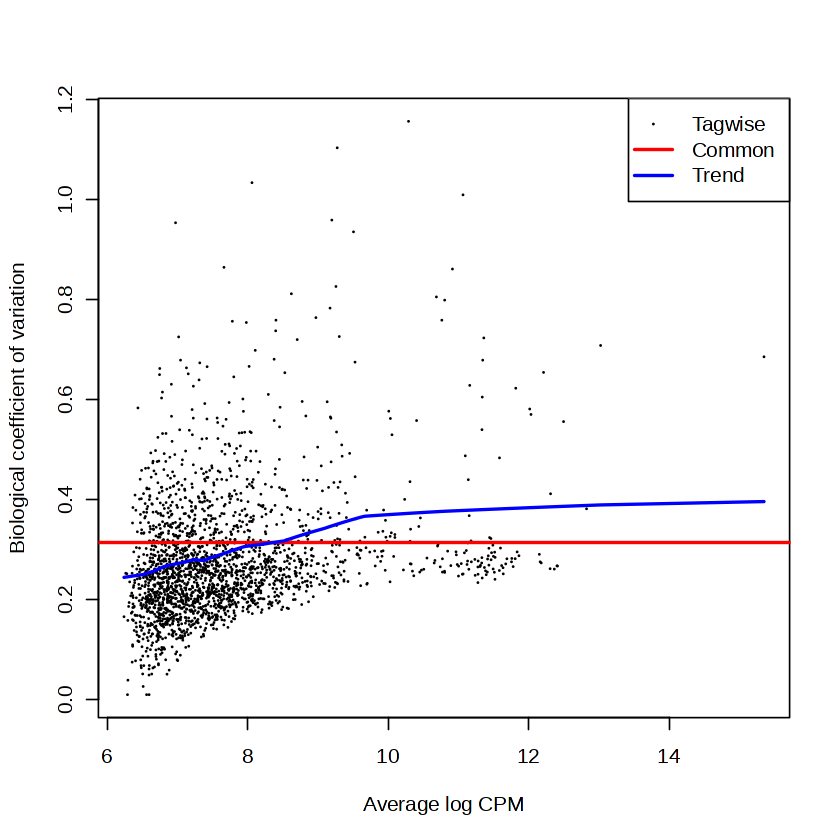

In [19]:
plotBCV(y)

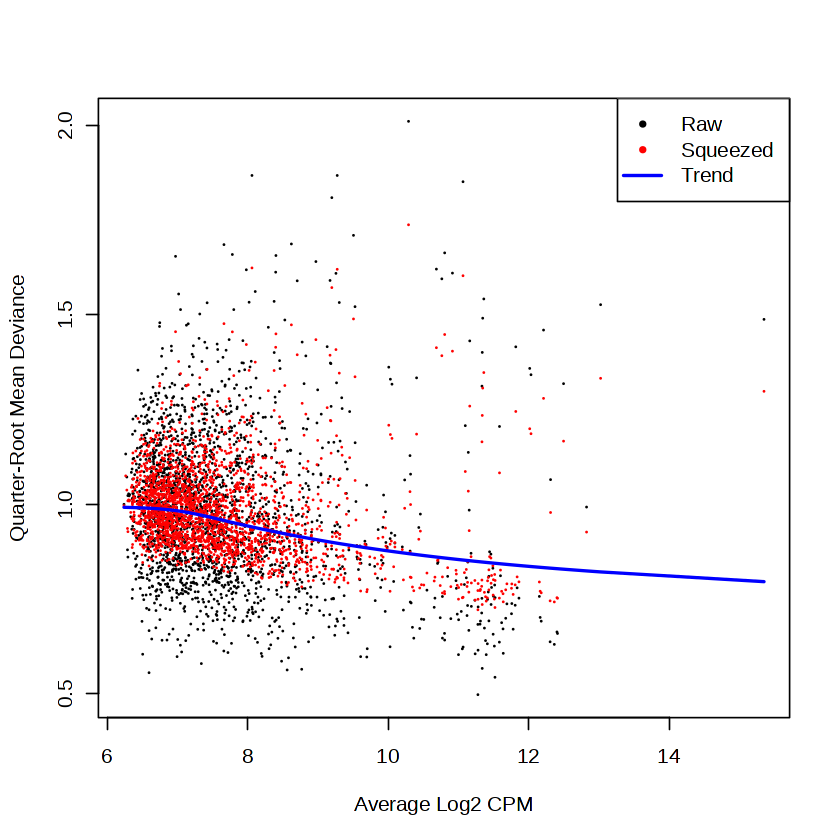

In [20]:
plotQLDisp(fit)

In [21]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Pf-PV-Hrv232-1,Pf-PV-Hrv232-2,Pf-PV-Hrv232-3,Pf-PV-Hrv236-1,Pf-PV-Hrv236-2,Pf-PV-Hrv236-3,UI-PV-Hrv232-1,UI-PV-Hrv232-2,UI-PV-Hrv232-3,UI-PV-Hrv236-1,UI-PV-Hrv236-2,UI-PV-Hrv236-3
CACNA1C,30.388126,0.00000,0.00000,43.93586,27.05366,88.39678,175.94058,98.51877,91.94657,258.16960,134.34933,127.21079
COL3A1,402.642671,0.00000,337.18287,812.81340,387.76906,265.19035,2294.87719,1088.39787,683.03166,2099.32649,2586.22467,1266.80748
NFIC,45.582189,42.58702,48.16898,65.90379,108.21462,58.93119,145.34222,117.28425,123.47111,163.05448,161.21920,164.31394
MEIS2,45.582189,0.00000,0.00000,65.90379,45.08943,88.39678,84.14550,103.21014,102.45475,217.40598,127.63187,143.11214
COL1A2,174.731725,42.58702,168.59144,219.67930,81.16097,147.32797,283.03485,258.02536,265.33153,563.89676,470.22267,291.52473
COL5A2,68.373284,0.00000,24.08449,43.93586,99.19674,88.39678,420.72748,98.51877,162.87678,230.99385,201.52400,206.71754
INPP4B,7.597032,21.29351,0.00000,21.96793,153.30405,147.32797,114.74386,70.37055,194.40132,495.95739,295.56853,164.31394
JUNB,53.179221,85.17404,72.25347,43.93586,72.14308,117.86238,290.68444,201.72892,320.49947,122.29086,73.89213,132.51124
PDXK,144.343599,149.05458,240.84491,219.67930,108.21462,117.86238,99.44468,98.51877,91.94657,40.76362,60.45720,58.30495
REV3L,91.164378,42.58702,48.16898,65.90379,36.07154,88.39678,91.79509,103.21014,186.52018,197.02417,154.50173,159.01349


In [22]:
summary(decideTests(qlf))

       summed_celltype$infectionPf
Down                             0
NotSig                        2226
Up                               0

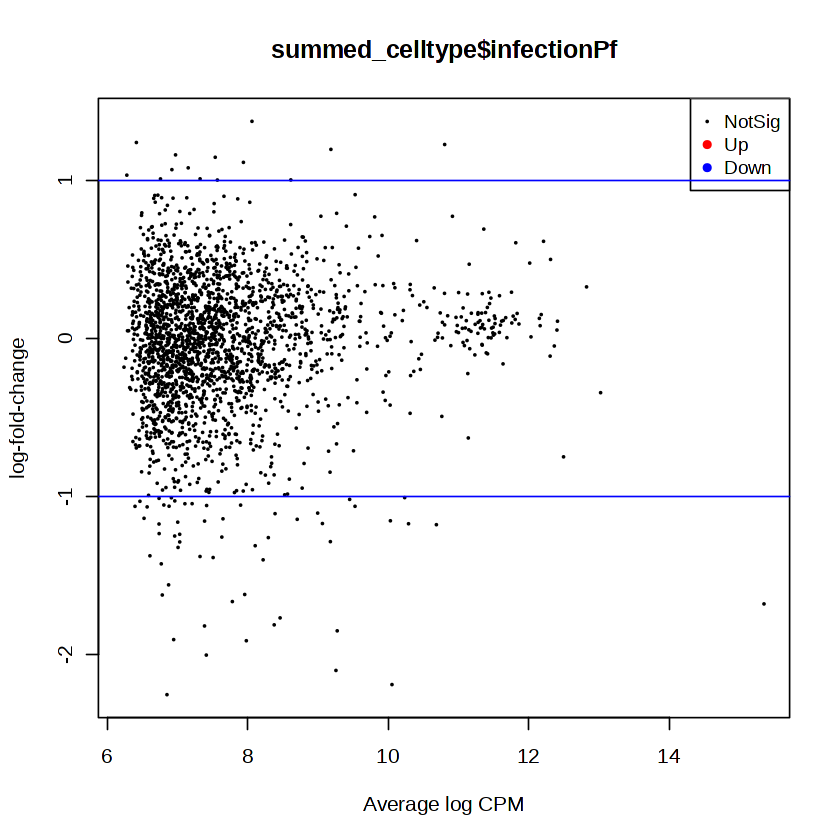

In [23]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

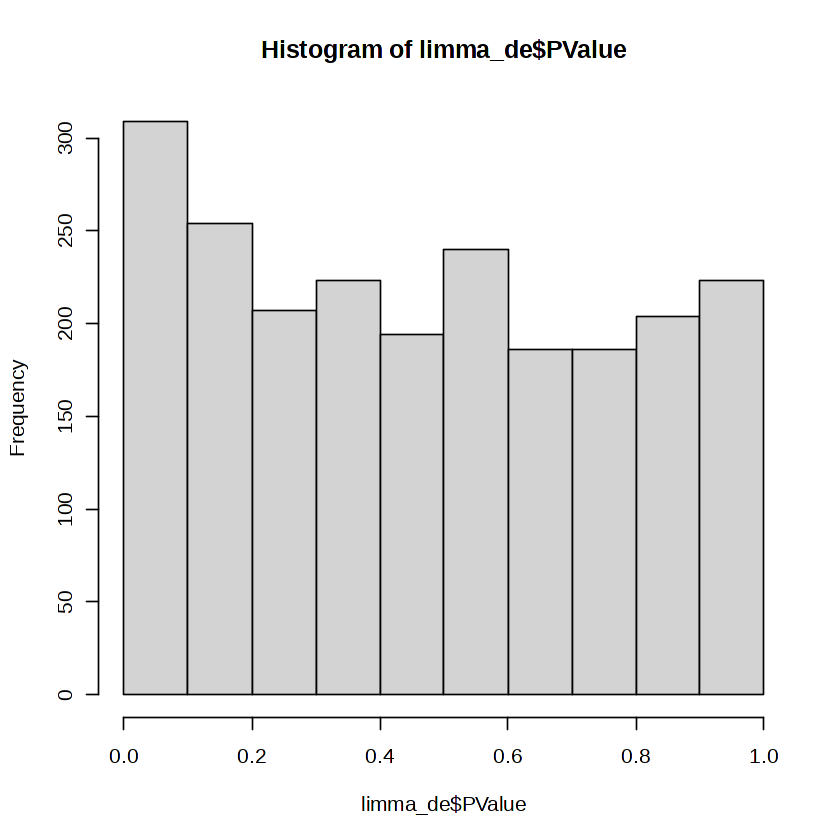

In [24]:
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

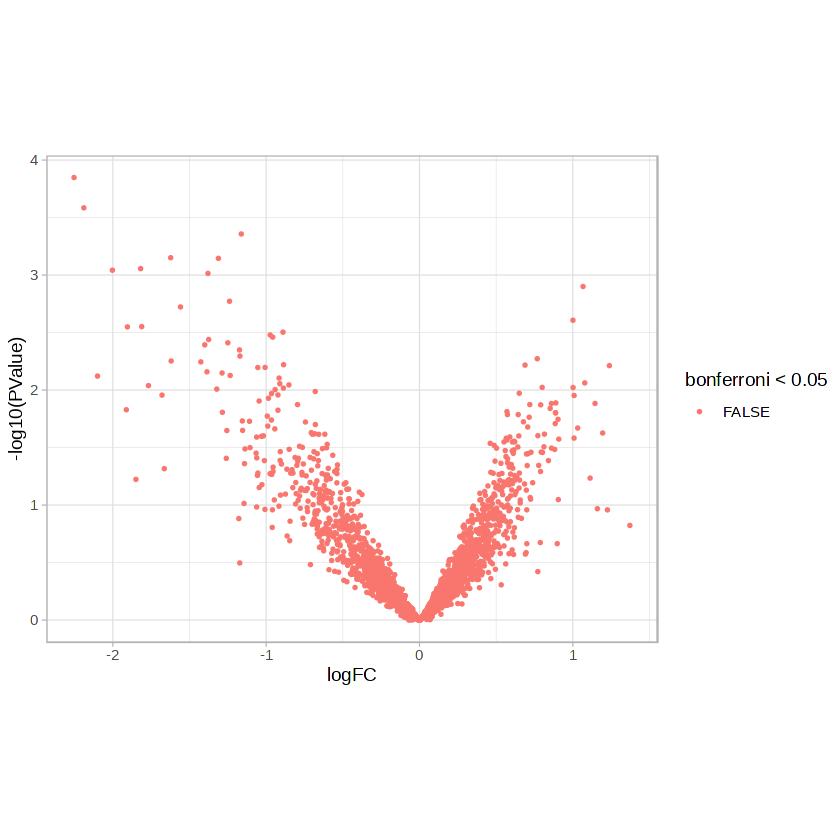

In [25]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

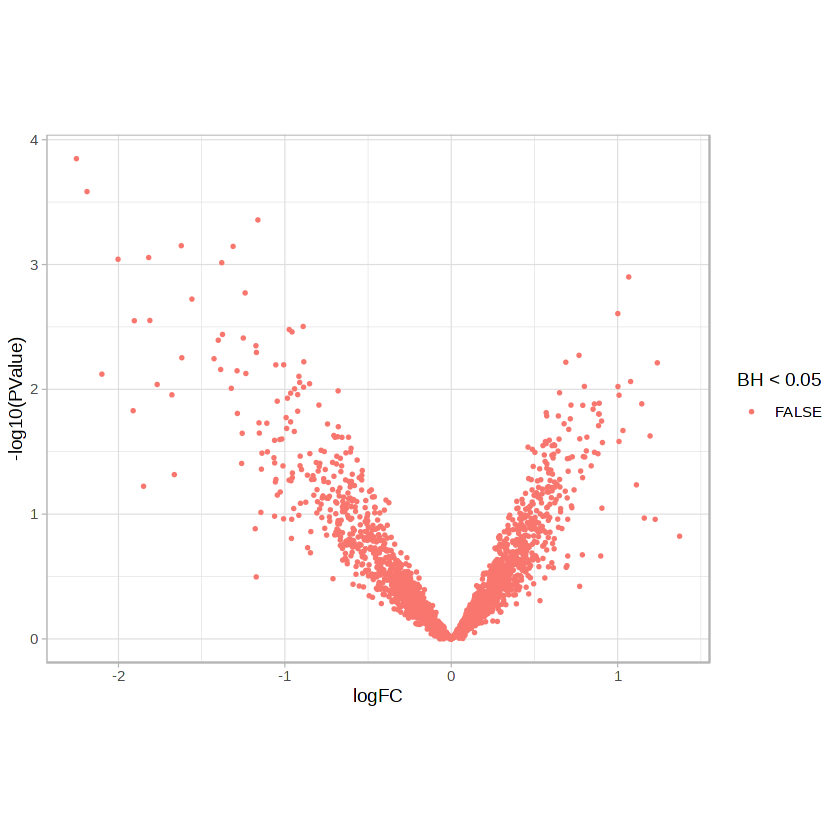

In [26]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
